In [49]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.utils import np_utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

import mlflow
import mlflow.tensorflow
import mlflow.keras

In [57]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

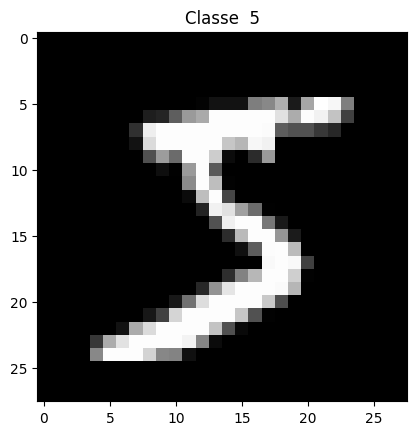

In [51]:
# mostrando a imagem
plt.imshow(X_train[0], cmap='gray')
plt.title(f'Classe  {y_train[0]}')
plt.show()

In [52]:
class Modelo(): 
    def __init__(self, input_shape, num_classes, num_units, dense_activation, output_activation, dropout_rate, optimizer, loss, metrics):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_units = num_units
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
    
    def log_parametros(self):
        mlflow.log_param("input_shape", self.input_shape)
        mlflow.log_param("num_classes", self.num_classes)
        mlflow.log_param("num_units", self.num_units)
        mlflow.log_param("dense_activation", self.dense_activation)
        mlflow.log_param("output_activation", self.output_activation)
        mlflow.log_param("dropout_rate", self.dropout_rate)
        mlflow.log_param("optimizer", self.optimizer)
        mlflow.log_param("loss", self.loss)
        mlflow.log_param("metrics", self.metrics)

    def log_metricas(self, model, X_test, y_test):
        score = model.evaluate(X_test, y_test, verbose=0)
        mlflow.log_metric("Teste - Loss", score[0])
        mlflow.log_metric("Teste - Acurácia", score[1])


    def log_history(self, history):
        for key in history.history.keys():
            mlflow.log_metric(key, history.history[key][-1])
            
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Acurácia do Modelo')
        plt.ylabel('Acurácia')
        plt.xlabel('Época')
        plt.legend(['Treino', 'Teste'], loc='upper left')
        plt.savefig('./images/accuracy.png')
        plt.close()
        mlflow.log_artifact('./images/accuracy.png')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Perda do Modelo')
        plt.ylabel('Perda')
        plt.xlabel('Época')
        plt.legend(['Treino', 'Teste'], loc='upper left')
        plt.savefig('./images/loss.png')
        plt.close()
        mlflow.log_artifact('./images/loss.png')

    def log_execution(self, execution_id):
        mlflow.log_param("execution_id", execution_id)

    def create_model(self):
        inputs = Input(shape=self.input_shape)
        x = Dense(self.num_units, activation=self.dense_activation)(inputs)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(self.num_units, activation=self.dense_activation)(x)
        x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_classes, activation=self.output_activation)(x)
        model = Model(inputs=inputs, outputs=outputs)
        
        return model
    
    def compile_model(self):
        model = self.create_model()
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)

        return model
    
    def train_model(self, model, X_train, y_train, X_test, y_test, epochs, batch_size):
        history = model.fit(X_train,
                  y_train,
                  validation_data=(X_test, y_test),
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0)
        
        return model, history
    
    @classmethod
    def reshape(self, X_train, X_test):
        linha, coluna, pixel = X_train.shape
        X_train = X_train.reshape(linha, coluna * pixel).astype('float32')

        linha, coluna, pixel = X_test.shape
        X_test = X_test.reshape(linha, coluna * pixel).astype('float32')
        
        return X_train, X_test
    
    @classmethod
    def normalize(self, X_train, X_test):
        X_train /=  255
        X_test /= 255
        return X_train, X_test
    
    @classmethod
    def to_categorical(self, y_train, y_test, num_classes):
        y_train = np_utils.to_categorical(y_train, num_classes)
        y_test = np_utils.to_categorical(y_test, num_classes)
        return y_train, y_test

In [53]:
# Fazendo o reshape dos dados
X_train, X_test = Modelo.reshape(X_train, X_test)

# normalizando os dados
X_train, X_test = Modelo.normalize(X_train, X_test)

# transformando os dados em categoricos
y_train, y_test = Modelo.to_categorical(y_train, y_test, 10)

In [54]:
def experiments():
    for num_units in [64, 128, 256]:
        for dropout_rate in [0.2, 0.3, 0.4]:
            for dense_activation in ['relu', 'tanh']:
                for output_activation in ['softmax', 'sigmoid']:
                    for optimizer in ['adam', 'rmsprop']:
                        for loss in ['categorical_crossentropy', 'mean_squared_error']:
                            for metrics in [['accuracy'], ['accuracy', 'mse']]:
                                yield num_units, dropout_rate, dense_activation, output_activation, optimizer, loss, metrics

for num_units, dropout_rate, dense_activation, output_activation, optimizer, loss, metrics in experiments():
    mlflow.set_experiment("DL - MNIST")
    with mlflow.start_run():
        modelo = Modelo(input_shape=(784,),
                    num_classes=len(y_train[0]),
                    num_units=num_units,
                    dense_activation=dense_activation,
                    output_activation=output_activation,
                    dropout_rate=dropout_rate,
                    optimizer=optimizer,
                    loss=loss,
                    metrics=metrics)
        
        modelo.log_parametros()

        modelo_treinado, histoy = modelo.train_model(model=modelo.compile_model(), 
                                            X_train=X_train,
                                            y_train=y_train,
                                            X_test=X_test, 
                                            y_test=y_test, 
                                            epochs=10,
                                            batch_size=128)

        modelo.log_history(histoy)

        modelo.log_metricas(modelo_treinado, X_test, y_test)
        mlflow.keras.log_model(modelo_treinado, "model")

        modelo.log_execution(execution_id=mlflow.active_run().info.run_id)

    mlflow.end_run()

2023/12/23 11:18:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\lmonf\AppData\Local\Temp\tmp2445yoxf\model\data\model\assets


In [55]:
modelo_treinado.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9791


[0.06791356950998306, 0.9790999889373779]

1/1 [==============================] - 0s 65ms/step
Previsto: 7


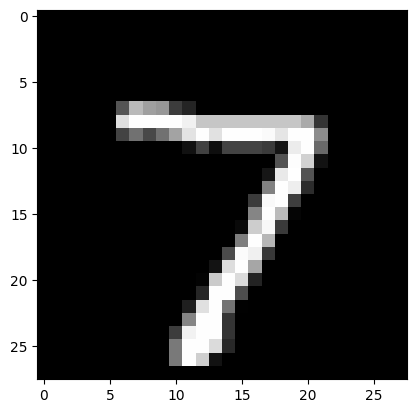

In [56]:
previsto = np.argmax(modelo_treinado.predict(X_test[0].reshape(1, 784)))
print(f'Previsto: {previsto}')
plt.imshow(X_test[0].reshape(28, 28), cmap='gray')
plt.show()